In [16]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.functional as F
# from sklearn.model_selection import GridSearchCV
# from skorch import NeuralNetClassifier
import itertools
import torch.optim as optim
# from torchinfo import summary
# import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("NVIDIA GPU available, running stuff on GPU" if DEVICE.type == "cuda" else "No NVIDIA GPU available, running stuff on CPU")

NVIDIA GPU available, running stuff on GPU


In [17]:
ROOT_DIR = r"C:\Users\delga\Documents\programming\datasets"

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])  #Known metrics from CIFAR10
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])   #Known metrics from CIFAR10
])

full_train_dataset = datasets.CIFAR10(
    root=ROOT_DIR, 
    download=False, 
    train=True, 
    transform=train_transforms
    )

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset=full_train_dataset,
    lengths=[train_size, val_size],
    generator=torch.Generator().manual_seed(22)
)

val_dataset.dataset.transform = val_transforms      # Replace val transform (so validation doesn't use augmentations)

test_dataset = datasets.CIFAR10(
    root=ROOT_DIR, 
    download=False, 
    train=False, 
    transform=val_transforms
    )

print(f"\nCompleted data loading and splits:\n * Train dataset: {len(train_dataset)} samples\n * Validation dataset: {len(val_dataset)} samples\n * Test dataset: {len(test_dataset)} samples")

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=True, num_workers=1, pin_memory=True)


Completed data loading and splits:
 * Train dataset: 45000 samples
 * Validation dataset: 5000 samples
 * Test dataset: 10000 samples


In [18]:
# indices = torch.arange(100)
# tiny_train_dataset = Subset(dataset=train_dataset, indices=indices)
# tiny_loader = DataLoader(dataset=tiny_train_dataset, batch_size=16, shuffle=True)
# images, labels = next(iter(tiny_loader))
# print(images.shape, labels.shape)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    """
    A simple Convolutional Neural Network for CIFAR-10 classification.
    Input: 3x32x32 images
    Output: 10 class logits
    """
    def __init__(self, dropout=0.25):
        super(CNN, self).__init__()
        
        # --- Convolutional layers ---
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # --- Batch Normalization layers + Pooling layer ---
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # --- Fully Connected layers ---
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)  # 10 CIFAR-10 classes
        
        # --- Regularization ---
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Convolutional feature extraction
        x = self.pool(F.relu(self.bn1(self.conv1(x))))   # Output: [B, 32, 16, 16]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))   # Output: [B, 64, 8, 8]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))   # Output: [B, 128, 4, 4]

        # Flatten for fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [20]:
model = CNN().to(DEVICE)
# summary(model, input_size=(16, 3, 32, 32))

In [21]:
def train_and_validate(model, train_loader, val_loader, epochs, criterion, optimizer):
    """
    Trains the model {epochs} number of times, within each epoch it
    trains the whole data inside the loader and later evaluates it using
    the validation loader
    """
    train_losses, val_losses, val_accuracies = [], [], []
    
    for epoch in range(epochs):
        # --- Training phase ---
        model.train()
        total_train_loss = 0
        
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- Evaluation phase ---
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.2f}%")
    
    # --- Plotting the curves ---    
    epochs_range = range(1, epochs + 1)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Validation Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", color="green")
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, val_losses, val_accuracies
          
        
def test_loop(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    return accuracy


---Testing configuration: learning rate=0.01, weight decay=0.001, dropout=0.25
Epoch [1/5] | Train Loss: 2.1638 | Val Loss: 1.5645 | Val Acc: 41.74%
Epoch [2/5] | Train Loss: 1.5678 | Val Loss: 1.4062 | Val Acc: 49.88%
Epoch [3/5] | Train Loss: 1.3688 | Val Loss: 1.1673 | Val Acc: 57.14%
Epoch [4/5] | Train Loss: 1.2155 | Val Loss: 1.1358 | Val Acc: 59.84%
Epoch [5/5] | Train Loss: 1.1238 | Val Loss: 1.0480 | Val Acc: 63.30%


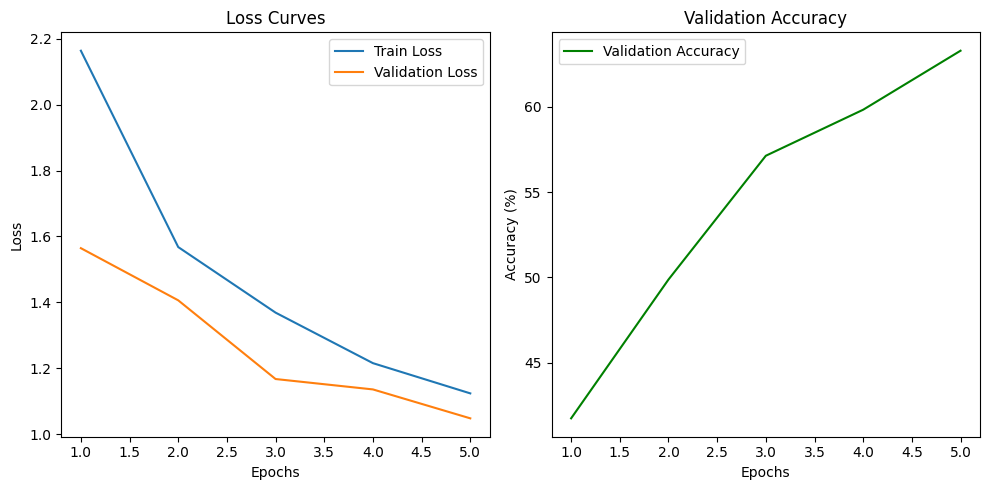


---Testing configuration: learning rate=0.01, weight decay=0.001, dropout=0.3
Epoch [1/5] | Train Loss: 2.0204 | Val Loss: 1.5222 | Val Acc: 42.24%
Epoch [2/5] | Train Loss: 1.5418 | Val Loss: 1.3581 | Val Acc: 52.10%
Epoch [3/5] | Train Loss: 1.3280 | Val Loss: 1.1703 | Val Acc: 57.64%
Epoch [4/5] | Train Loss: 1.1896 | Val Loss: 1.0961 | Val Acc: 61.46%
Epoch [5/5] | Train Loss: 1.1260 | Val Loss: 1.0423 | Val Acc: 64.30%


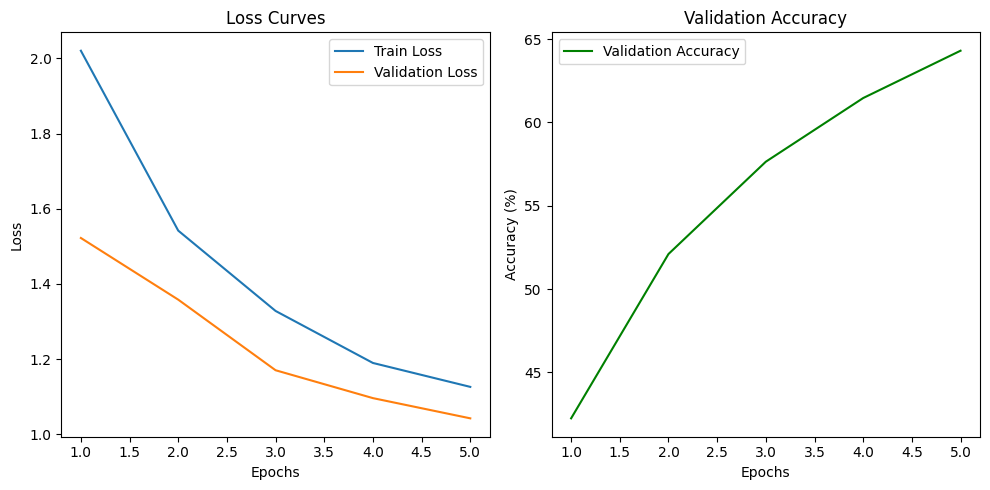


---Testing configuration: learning rate=0.01, weight decay=0.001, dropout=0.4
Epoch [1/5] | Train Loss: 2.1679 | Val Loss: 1.5990 | Val Acc: 40.10%
Epoch [2/5] | Train Loss: 1.6141 | Val Loss: 1.4316 | Val Acc: 47.30%
Epoch [3/5] | Train Loss: 1.3939 | Val Loss: 1.1832 | Val Acc: 57.54%
Epoch [4/5] | Train Loss: 1.2742 | Val Loss: 1.1737 | Val Acc: 58.58%
Epoch [5/5] | Train Loss: 1.1962 | Val Loss: 1.1974 | Val Acc: 58.12%


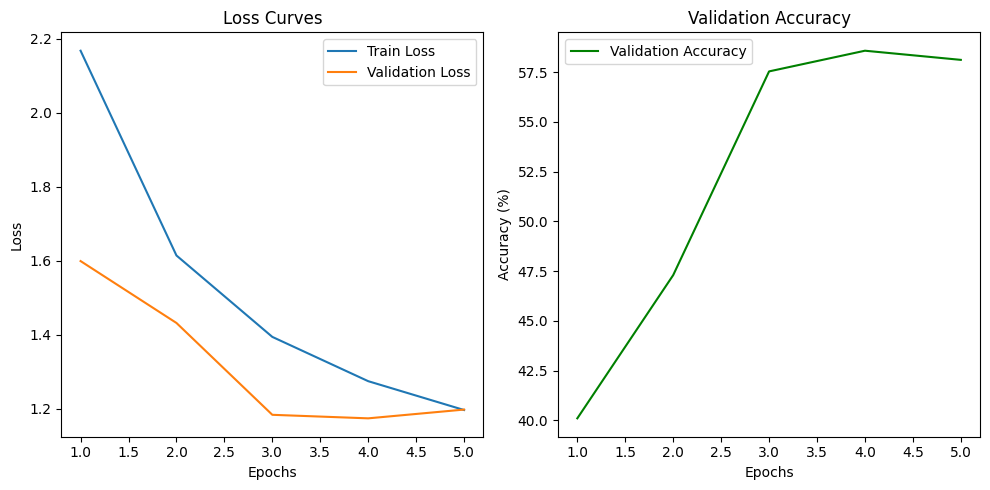


---Testing configuration: learning rate=0.01, weight decay=0.0001, dropout=0.25
Epoch [1/5] | Train Loss: 2.0635 | Val Loss: 1.5960 | Val Acc: 41.72%
Epoch [2/5] | Train Loss: 1.5637 | Val Loss: 1.2811 | Val Acc: 54.34%
Epoch [3/5] | Train Loss: 1.3851 | Val Loss: 1.2640 | Val Acc: 53.80%
Epoch [4/5] | Train Loss: 1.2740 | Val Loss: 1.0867 | Val Acc: 63.00%
Epoch [5/5] | Train Loss: 1.1616 | Val Loss: 0.9884 | Val Acc: 65.80%


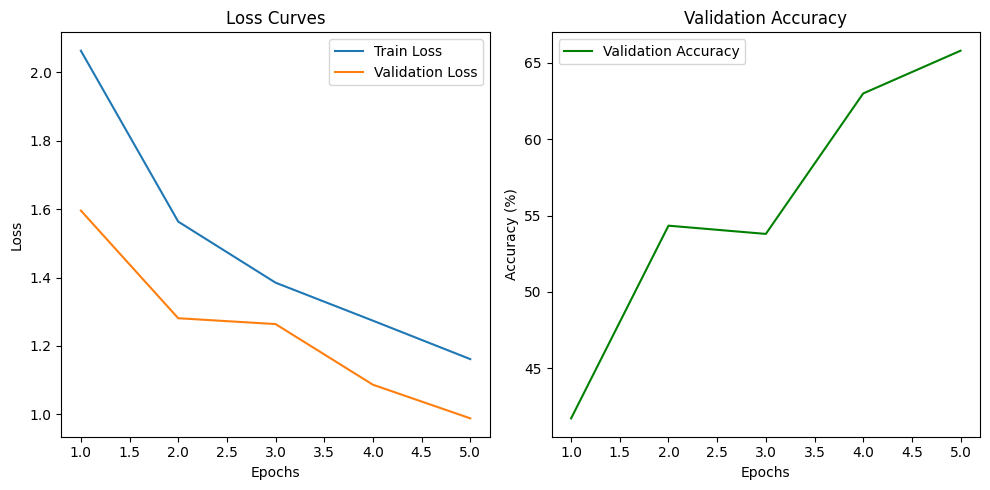


---Testing configuration: learning rate=0.01, weight decay=0.0001, dropout=0.3
Epoch [1/5] | Train Loss: 2.1871 | Val Loss: 1.7699 | Val Acc: 27.86%
Epoch [2/5] | Train Loss: 1.8307 | Val Loss: 1.6344 | Val Acc: 40.98%
Epoch [3/5] | Train Loss: 1.6755 | Val Loss: 1.4134 | Val Acc: 47.70%
Epoch [4/5] | Train Loss: 1.4805 | Val Loss: 1.1864 | Val Acc: 55.84%
Epoch [5/5] | Train Loss: 1.2991 | Val Loss: 1.0582 | Val Acc: 62.06%


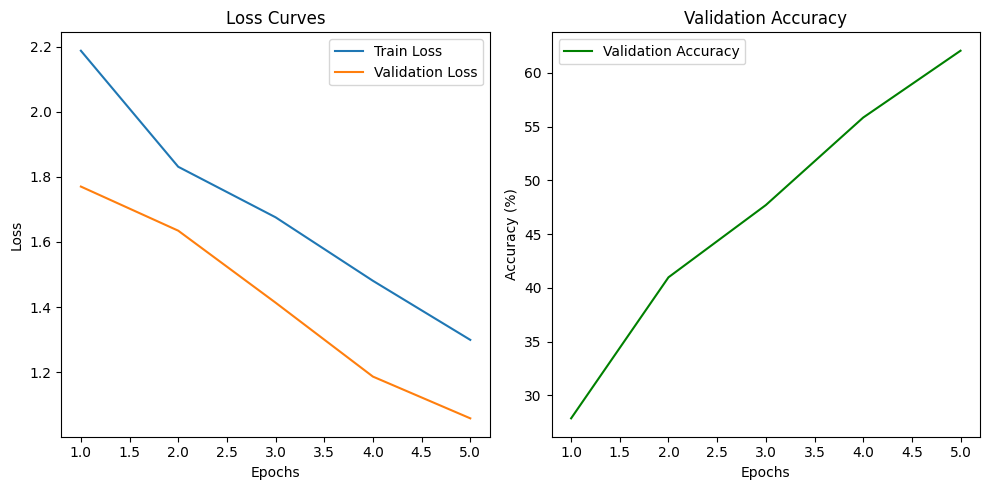


---Testing configuration: learning rate=0.01, weight decay=0.0001, dropout=0.4
Epoch [1/5] | Train Loss: 2.1583 | Val Loss: 1.6895 | Val Acc: 34.86%
Epoch [2/5] | Train Loss: 1.7225 | Val Loss: 1.5269 | Val Acc: 42.16%
Epoch [3/5] | Train Loss: 1.5626 | Val Loss: 1.3739 | Val Acc: 50.72%
Epoch [4/5] | Train Loss: 1.4473 | Val Loss: 1.1849 | Val Acc: 57.84%
Epoch [5/5] | Train Loss: 1.3237 | Val Loss: 1.2011 | Val Acc: 57.98%


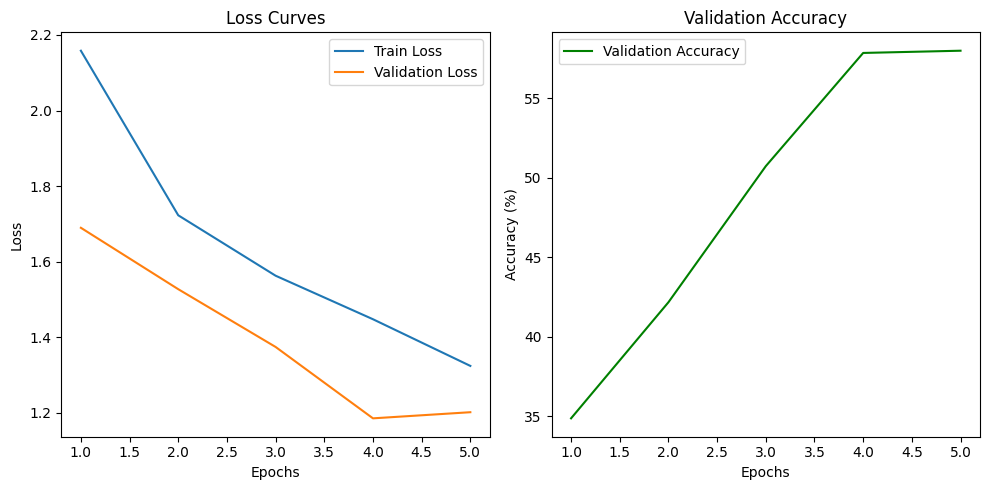


---Testing configuration: learning rate=0.01, weight decay=1e-05, dropout=0.25
Epoch [1/5] | Train Loss: 2.1546 | Val Loss: 1.8379 | Val Acc: 26.08%
Epoch [2/5] | Train Loss: 1.8410 | Val Loss: 1.6192 | Val Acc: 39.14%
Epoch [3/5] | Train Loss: 1.7230 | Val Loss: 1.4949 | Val Acc: 44.78%
Epoch [4/5] | Train Loss: 1.6410 | Val Loss: 1.4081 | Val Acc: 49.38%
Epoch [5/5] | Train Loss: 1.4945 | Val Loss: 1.1639 | Val Acc: 56.50%


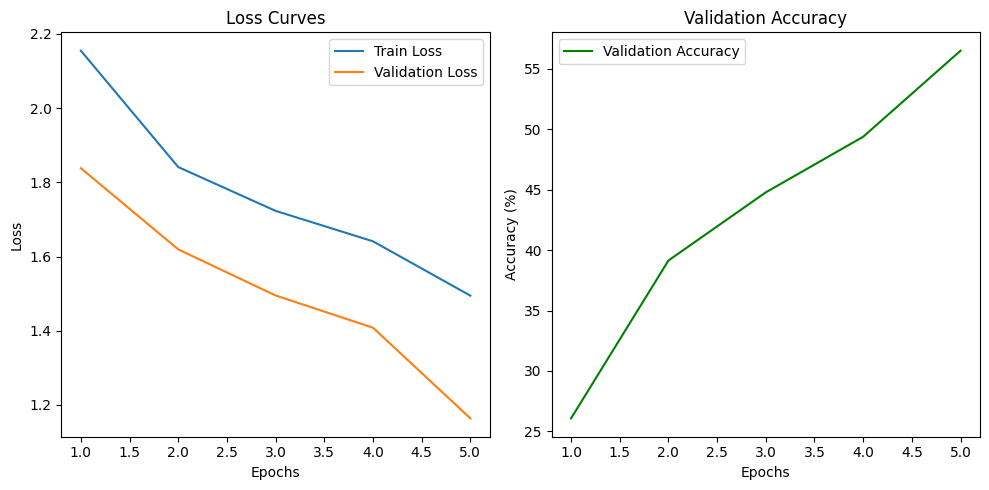


---Testing configuration: learning rate=0.01, weight decay=1e-05, dropout=0.3
Epoch [1/5] | Train Loss: 2.2741 | Val Loss: 1.8189 | Val Acc: 31.52%
Epoch [2/5] | Train Loss: 1.8495 | Val Loss: 1.5665 | Val Acc: 41.84%
Epoch [3/5] | Train Loss: 1.6508 | Val Loss: 1.3981 | Val Acc: 50.58%
Epoch [4/5] | Train Loss: 1.4136 | Val Loss: 1.2230 | Val Acc: 56.58%
Epoch [5/5] | Train Loss: 1.2346 | Val Loss: 1.0941 | Val Acc: 61.34%


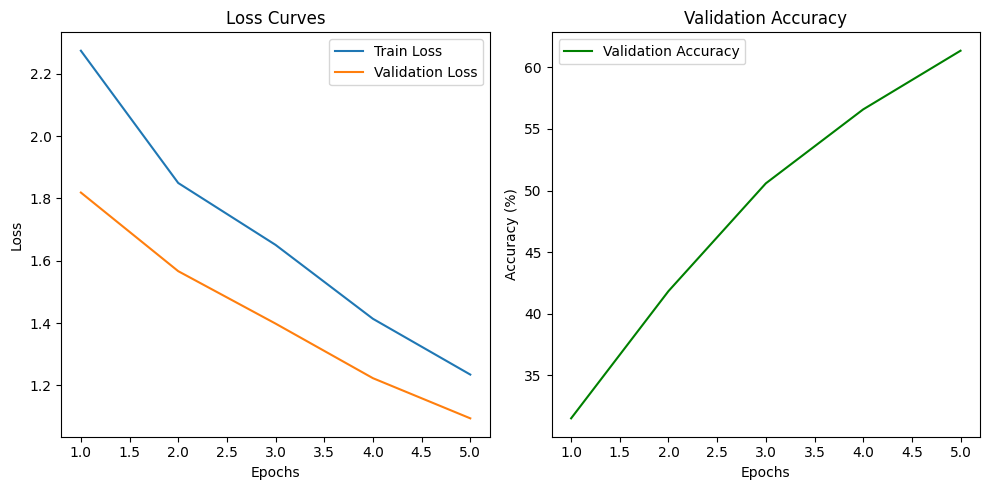


---Testing configuration: learning rate=0.01, weight decay=1e-05, dropout=0.4
Epoch [1/5] | Train Loss: 2.3709 | Val Loss: 1.8954 | Val Acc: 27.00%
Epoch [2/5] | Train Loss: 1.9777 | Val Loss: 1.8050 | Val Acc: 26.06%
Epoch [3/5] | Train Loss: 1.8697 | Val Loss: 1.6456 | Val Acc: 34.54%
Epoch [4/5] | Train Loss: 1.7824 | Val Loss: 1.5366 | Val Acc: 42.72%
Epoch [5/5] | Train Loss: 1.6775 | Val Loss: 1.4267 | Val Acc: 44.72%


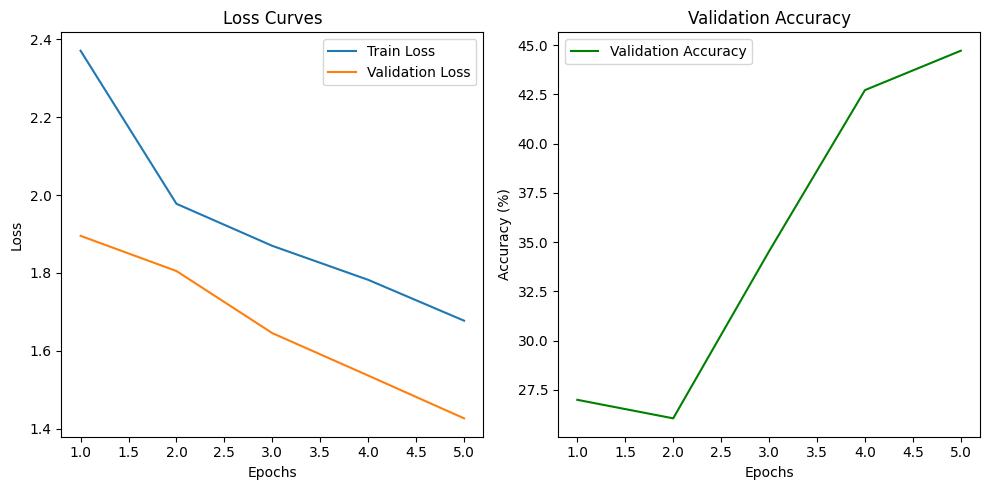


---Testing configuration: learning rate=0.005, weight decay=0.001, dropout=0.25
Epoch [1/5] | Train Loss: 1.6234 | Val Loss: 1.3407 | Val Acc: 50.96%
Epoch [2/5] | Train Loss: 1.1733 | Val Loss: 1.0686 | Val Acc: 62.04%
Epoch [3/5] | Train Loss: 1.0361 | Val Loss: 0.9854 | Val Acc: 64.58%
Epoch [4/5] | Train Loss: 0.9542 | Val Loss: 1.0394 | Val Acc: 64.70%
Epoch [5/5] | Train Loss: 0.9028 | Val Loss: 0.9293 | Val Acc: 66.94%


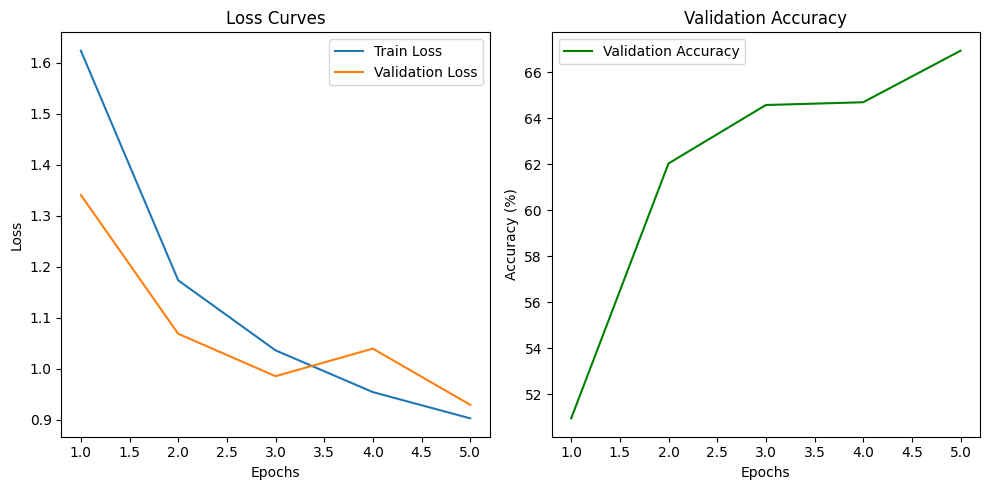


---Testing configuration: learning rate=0.005, weight decay=0.001, dropout=0.3
Epoch [1/5] | Train Loss: 1.6465 | Val Loss: 1.4990 | Val Acc: 44.94%
Epoch [2/5] | Train Loss: 1.2328 | Val Loss: 1.0216 | Val Acc: 64.18%
Epoch [3/5] | Train Loss: 1.0840 | Val Loss: 1.0337 | Val Acc: 64.00%
Epoch [4/5] | Train Loss: 1.0108 | Val Loss: 0.9602 | Val Acc: 66.18%
Epoch [5/5] | Train Loss: 0.9547 | Val Loss: 1.0298 | Val Acc: 65.82%


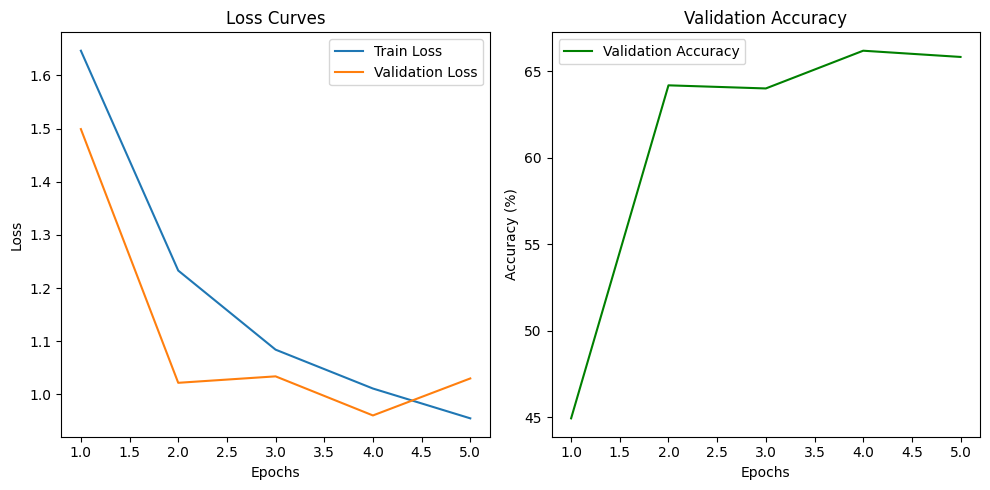


---Testing configuration: learning rate=0.005, weight decay=0.001, dropout=0.4
Epoch [1/5] | Train Loss: 1.7709 | Val Loss: 1.3171 | Val Acc: 52.66%
Epoch [2/5] | Train Loss: 1.3987 | Val Loss: 1.1800 | Val Acc: 58.22%
Epoch [3/5] | Train Loss: 1.2250 | Val Loss: 1.1672 | Val Acc: 59.44%
Epoch [4/5] | Train Loss: 1.1223 | Val Loss: 1.0831 | Val Acc: 63.16%
Epoch [5/5] | Train Loss: 1.0243 | Val Loss: 0.9040 | Val Acc: 68.98%


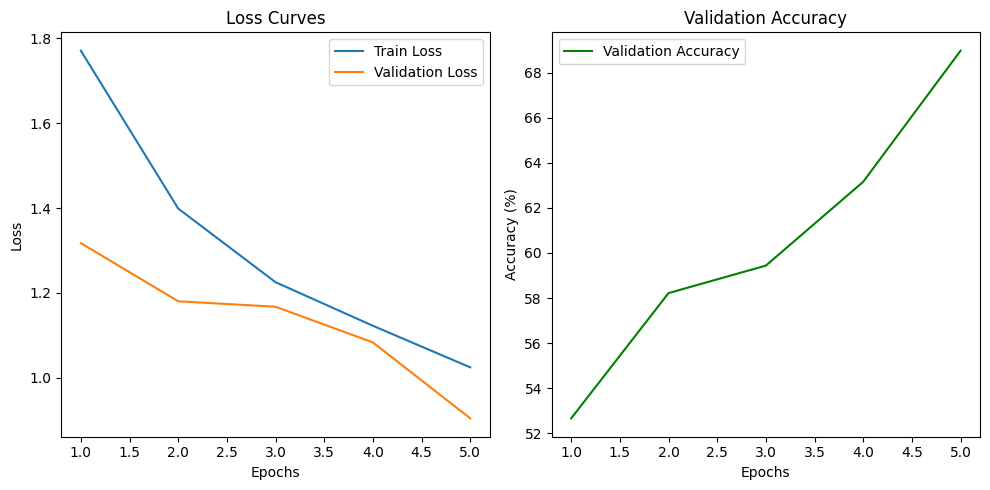


---Testing configuration: learning rate=0.005, weight decay=0.0001, dropout=0.25
Epoch [1/5] | Train Loss: 1.6629 | Val Loss: 1.2525 | Val Acc: 52.78%
Epoch [2/5] | Train Loss: 1.1880 | Val Loss: 1.1463 | Val Acc: 60.68%
Epoch [3/5] | Train Loss: 0.9901 | Val Loss: 0.9117 | Val Acc: 67.96%
Epoch [4/5] | Train Loss: 0.8655 | Val Loss: 0.8972 | Val Acc: 68.52%
Epoch [5/5] | Train Loss: 0.7836 | Val Loss: 0.8045 | Val Acc: 73.02%


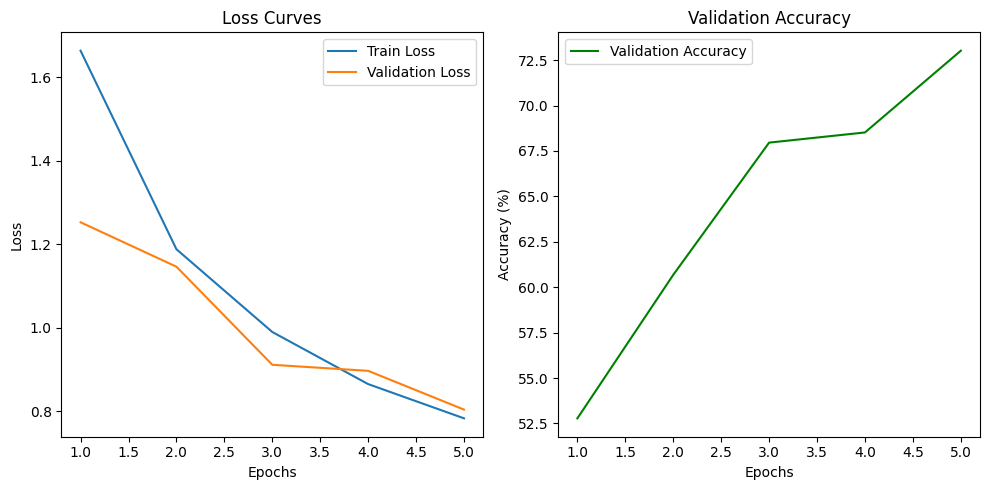


---Testing configuration: learning rate=0.005, weight decay=0.0001, dropout=0.3
Epoch [1/5] | Train Loss: 1.7231 | Val Loss: 1.3113 | Val Acc: 51.70%
Epoch [2/5] | Train Loss: 1.3176 | Val Loss: 1.0526 | Val Acc: 62.10%
Epoch [3/5] | Train Loss: 1.1103 | Val Loss: 0.9842 | Val Acc: 63.38%
Epoch [4/5] | Train Loss: 1.0005 | Val Loss: 0.8634 | Val Acc: 70.14%
Epoch [5/5] | Train Loss: 0.9126 | Val Loss: 0.8498 | Val Acc: 71.00%


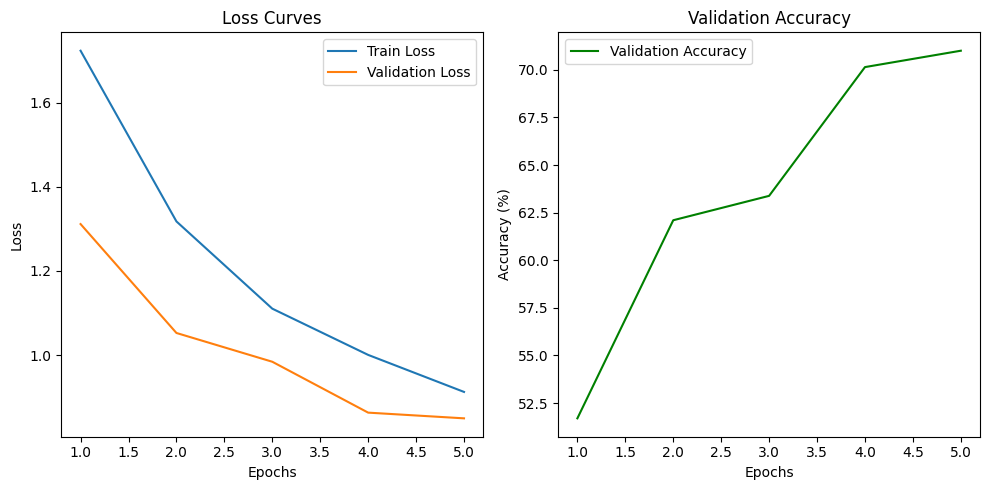


---Testing configuration: learning rate=0.005, weight decay=0.0001, dropout=0.4
Epoch [1/5] | Train Loss: 1.8434 | Val Loss: 1.3999 | Val Acc: 48.06%
Epoch [2/5] | Train Loss: 1.4503 | Val Loss: 1.2743 | Val Acc: 53.74%
Epoch [3/5] | Train Loss: 1.2815 | Val Loss: 1.1385 | Val Acc: 60.42%
Epoch [4/5] | Train Loss: 1.1719 | Val Loss: 0.9596 | Val Acc: 66.54%
Epoch [5/5] | Train Loss: 1.0839 | Val Loss: 0.9185 | Val Acc: 67.56%


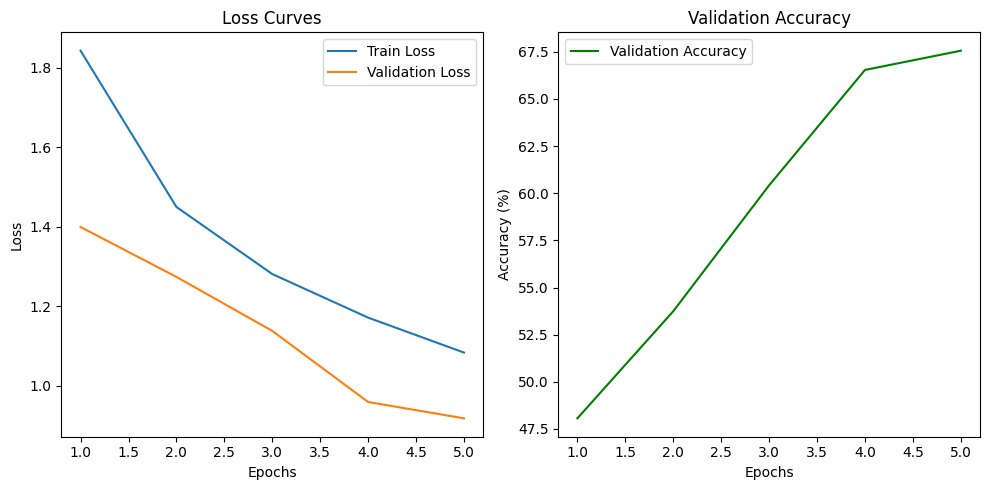


---Testing configuration: learning rate=0.005, weight decay=1e-05, dropout=0.25
Epoch [1/5] | Train Loss: 1.5981 | Val Loss: 1.2356 | Val Acc: 54.46%
Epoch [2/5] | Train Loss: 1.1594 | Val Loss: 0.9621 | Val Acc: 66.96%
Epoch [3/5] | Train Loss: 0.9661 | Val Loss: 0.8482 | Val Acc: 69.98%
Epoch [4/5] | Train Loss: 0.8506 | Val Loss: 0.8420 | Val Acc: 72.66%
Epoch [5/5] | Train Loss: 0.7659 | Val Loss: 0.7910 | Val Acc: 71.98%


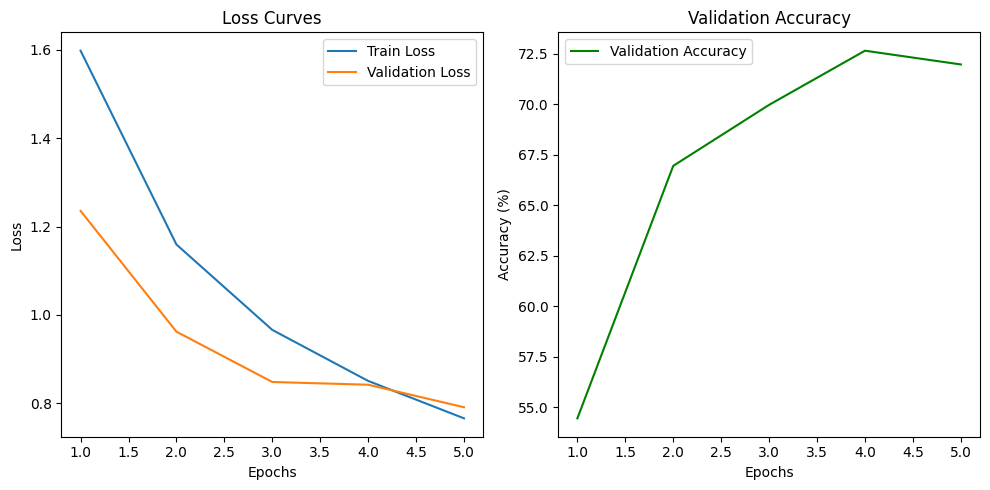


---Testing configuration: learning rate=0.005, weight decay=1e-05, dropout=0.3
Epoch [1/5] | Train Loss: 1.6773 | Val Loss: 1.4788 | Val Acc: 47.00%
Epoch [2/5] | Train Loss: 1.2463 | Val Loss: 1.0450 | Val Acc: 63.08%
Epoch [3/5] | Train Loss: 1.0520 | Val Loss: 0.9466 | Val Acc: 66.22%
Epoch [4/5] | Train Loss: 0.9367 | Val Loss: 0.8607 | Val Acc: 69.34%
Epoch [5/5] | Train Loss: 0.8565 | Val Loss: 0.8278 | Val Acc: 71.48%


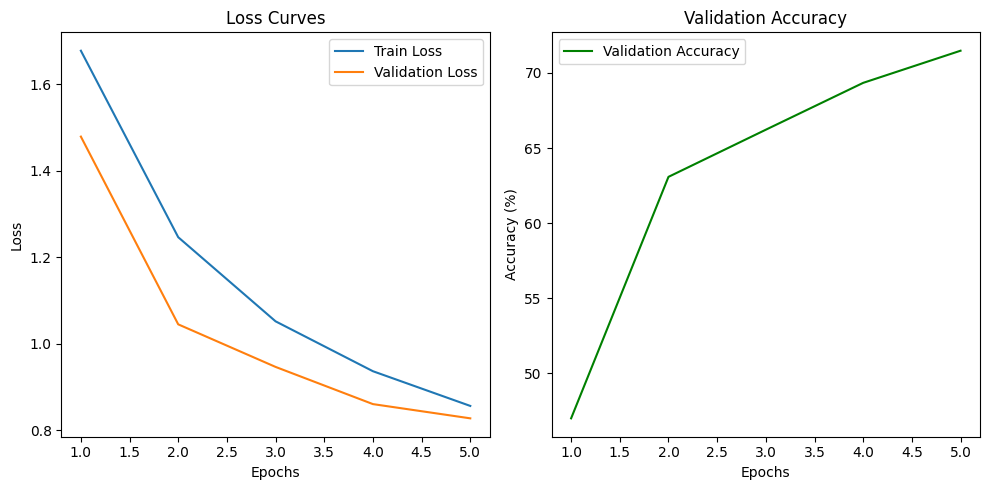


---Testing configuration: learning rate=0.005, weight decay=1e-05, dropout=0.4
Epoch [1/5] | Train Loss: 1.7638 | Val Loss: 1.3299 | Val Acc: 51.84%
Epoch [2/5] | Train Loss: 1.3656 | Val Loss: 1.1218 | Val Acc: 58.64%
Epoch [3/5] | Train Loss: 1.1925 | Val Loss: 1.0321 | Val Acc: 64.14%
Epoch [4/5] | Train Loss: 1.0679 | Val Loss: 0.9096 | Val Acc: 68.62%
Epoch [5/5] | Train Loss: 0.9782 | Val Loss: 0.9163 | Val Acc: 68.42%


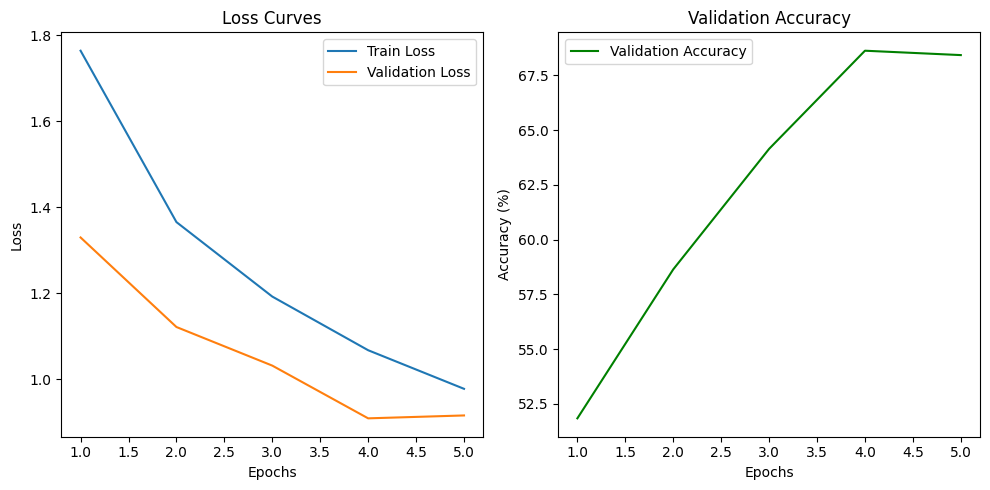


---Testing configuration: learning rate=0.001, weight decay=0.001, dropout=0.25
Epoch [1/5] | Train Loss: 1.3079 | Val Loss: 1.1252 | Val Acc: 59.96%
Epoch [2/5] | Train Loss: 0.9436 | Val Loss: 0.9616 | Val Acc: 67.52%
Epoch [3/5] | Train Loss: 0.8029 | Val Loss: 0.7898 | Val Acc: 72.00%
Epoch [4/5] | Train Loss: 0.7258 | Val Loss: 0.7847 | Val Acc: 73.26%
Epoch [5/5] | Train Loss: 0.6560 | Val Loss: 0.7382 | Val Acc: 74.30%


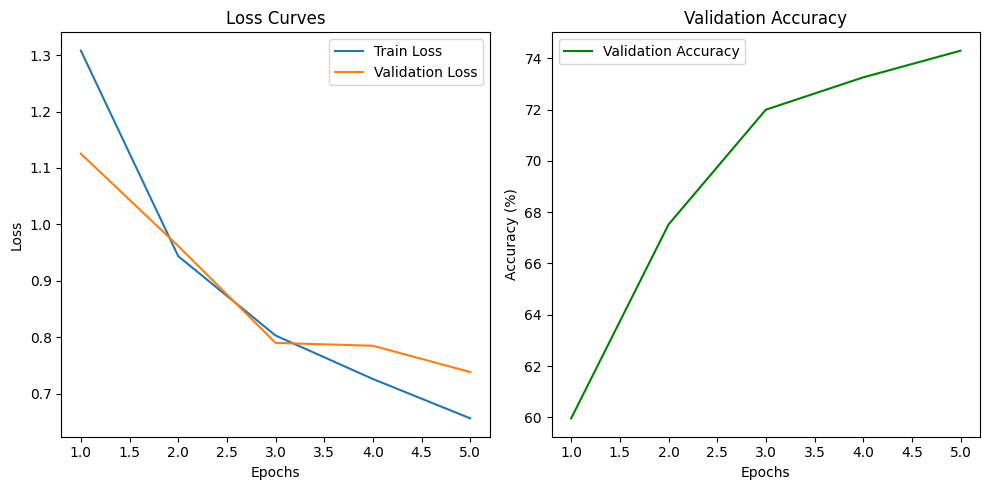


---Testing configuration: learning rate=0.001, weight decay=0.001, dropout=0.3
Epoch [1/5] | Train Loss: 1.3161 | Val Loss: 1.2394 | Val Acc: 56.74%
Epoch [2/5] | Train Loss: 0.9428 | Val Loss: 0.8960 | Val Acc: 67.80%
Epoch [3/5] | Train Loss: 0.8123 | Val Loss: 0.8171 | Val Acc: 70.70%
Epoch [4/5] | Train Loss: 0.7285 | Val Loss: 0.7517 | Val Acc: 72.32%
Epoch [5/5] | Train Loss: 0.6650 | Val Loss: 0.7007 | Val Acc: 75.50%


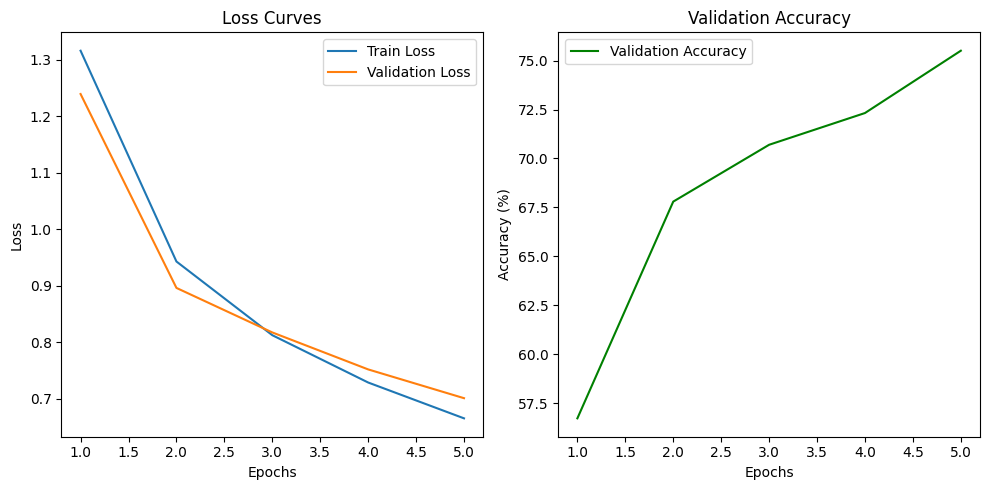


---Testing configuration: learning rate=0.001, weight decay=0.001, dropout=0.4
Epoch [1/5] | Train Loss: 1.3547 | Val Loss: 1.0768 | Val Acc: 62.02%
Epoch [2/5] | Train Loss: 0.9934 | Val Loss: 0.9280 | Val Acc: 66.86%
Epoch [3/5] | Train Loss: 0.8706 | Val Loss: 0.8757 | Val Acc: 68.64%
Epoch [4/5] | Train Loss: 0.7915 | Val Loss: 0.7503 | Val Acc: 73.58%
Epoch [5/5] | Train Loss: 0.7266 | Val Loss: 0.7211 | Val Acc: 74.50%


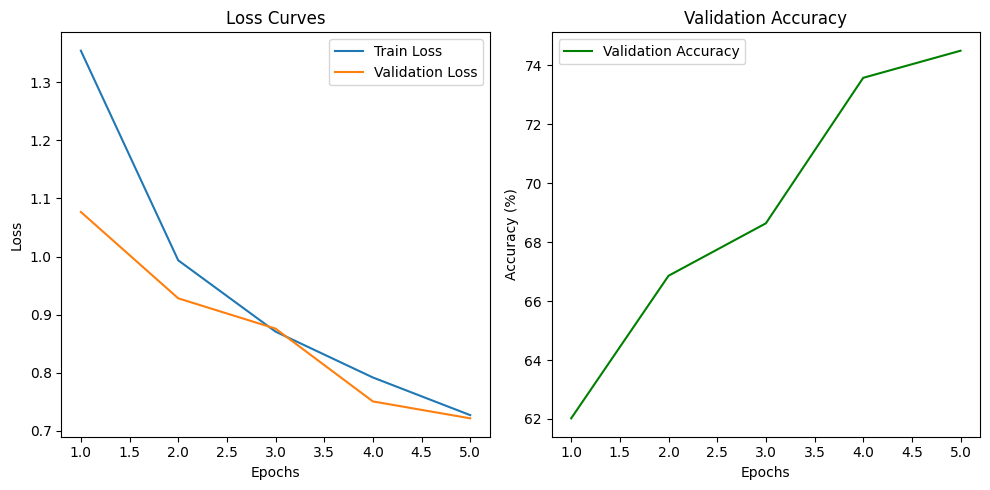


---Testing configuration: learning rate=0.001, weight decay=0.0001, dropout=0.25
Epoch [1/5] | Train Loss: 1.3124 | Val Loss: 1.0480 | Val Acc: 63.70%
Epoch [2/5] | Train Loss: 0.9272 | Val Loss: 0.8234 | Val Acc: 70.72%
Epoch [3/5] | Train Loss: 0.7863 | Val Loss: 0.8398 | Val Acc: 70.94%
Epoch [4/5] | Train Loss: 0.6973 | Val Loss: 0.7509 | Val Acc: 74.14%
Epoch [5/5] | Train Loss: 0.6315 | Val Loss: 0.7350 | Val Acc: 73.30%


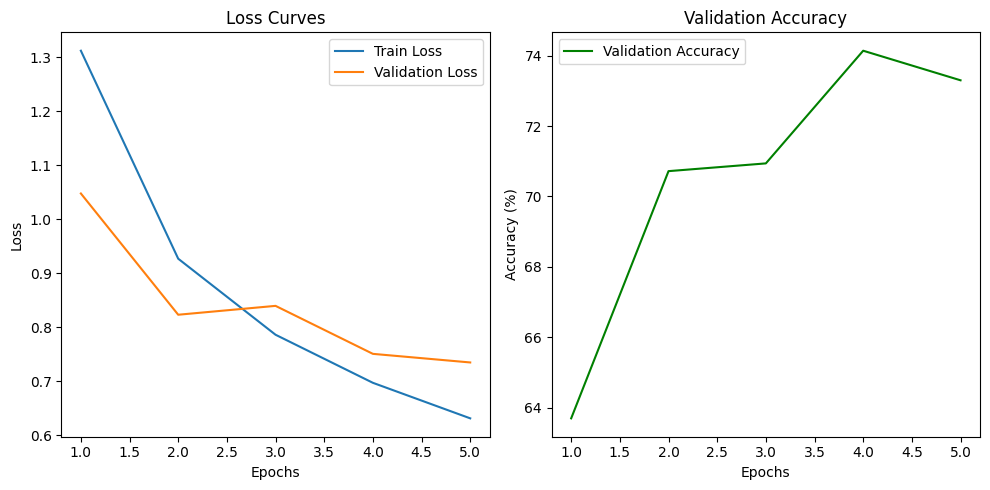


---Testing configuration: learning rate=0.001, weight decay=0.0001, dropout=0.3
Epoch [1/5] | Train Loss: 1.3723 | Val Loss: 0.9872 | Val Acc: 64.92%
Epoch [2/5] | Train Loss: 0.9774 | Val Loss: 0.9109 | Val Acc: 68.08%
Epoch [3/5] | Train Loss: 0.8354 | Val Loss: 0.7913 | Val Acc: 71.26%
Epoch [4/5] | Train Loss: 0.7479 | Val Loss: 0.7995 | Val Acc: 72.10%
Epoch [5/5] | Train Loss: 0.6801 | Val Loss: 0.7142 | Val Acc: 73.98%


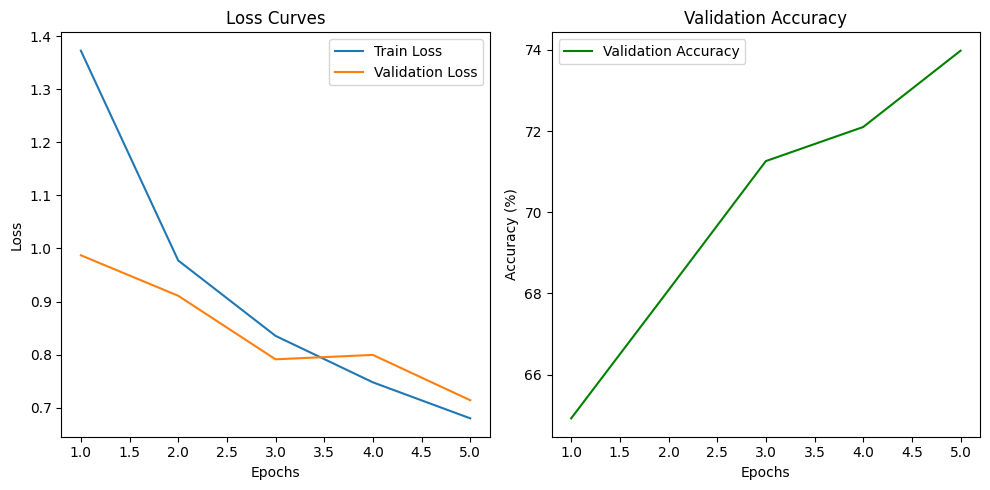


---Testing configuration: learning rate=0.001, weight decay=0.0001, dropout=0.4
Epoch [1/5] | Train Loss: 1.3939 | Val Loss: 1.0294 | Val Acc: 62.78%
Epoch [2/5] | Train Loss: 1.0085 | Val Loss: 0.9595 | Val Acc: 65.62%
Epoch [3/5] | Train Loss: 0.8642 | Val Loss: 0.7807 | Val Acc: 73.26%
Epoch [4/5] | Train Loss: 0.7736 | Val Loss: 0.8023 | Val Acc: 72.24%
Epoch [5/5] | Train Loss: 0.7115 | Val Loss: 0.7243 | Val Acc: 75.04%


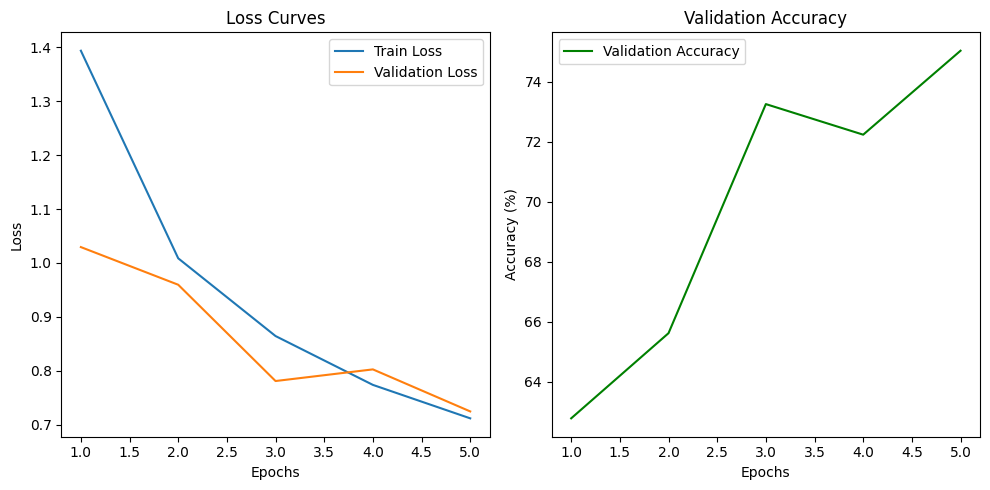


---Testing configuration: learning rate=0.001, weight decay=1e-05, dropout=0.25
Epoch [1/5] | Train Loss: 1.2918 | Val Loss: 0.9805 | Val Acc: 65.06%
Epoch [2/5] | Train Loss: 0.9048 | Val Loss: 0.8685 | Val Acc: 70.24%
Epoch [3/5] | Train Loss: 0.7717 | Val Loss: 0.8142 | Val Acc: 71.76%
Epoch [4/5] | Train Loss: 0.6879 | Val Loss: 0.7911 | Val Acc: 72.44%
Epoch [5/5] | Train Loss: 0.6185 | Val Loss: 0.7182 | Val Acc: 74.86%


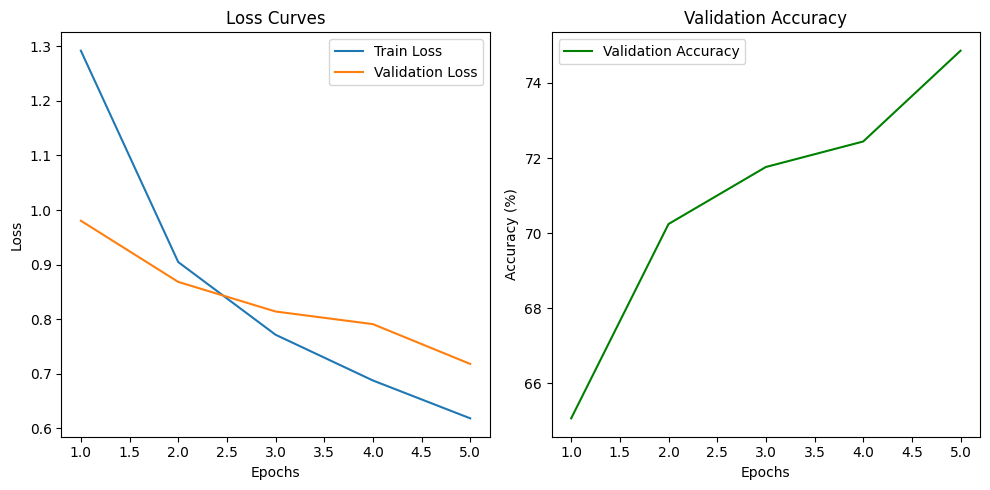


---Testing configuration: learning rate=0.001, weight decay=1e-05, dropout=0.3
Epoch [1/5] | Train Loss: 1.3303 | Val Loss: 1.1543 | Val Acc: 58.94%
Epoch [2/5] | Train Loss: 0.9467 | Val Loss: 0.8530 | Val Acc: 69.16%
Epoch [3/5] | Train Loss: 0.8109 | Val Loss: 0.7882 | Val Acc: 72.38%
Epoch [4/5] | Train Loss: 0.7259 | Val Loss: 0.7473 | Val Acc: 73.08%
Epoch [5/5] | Train Loss: 0.6611 | Val Loss: 0.7320 | Val Acc: 74.88%


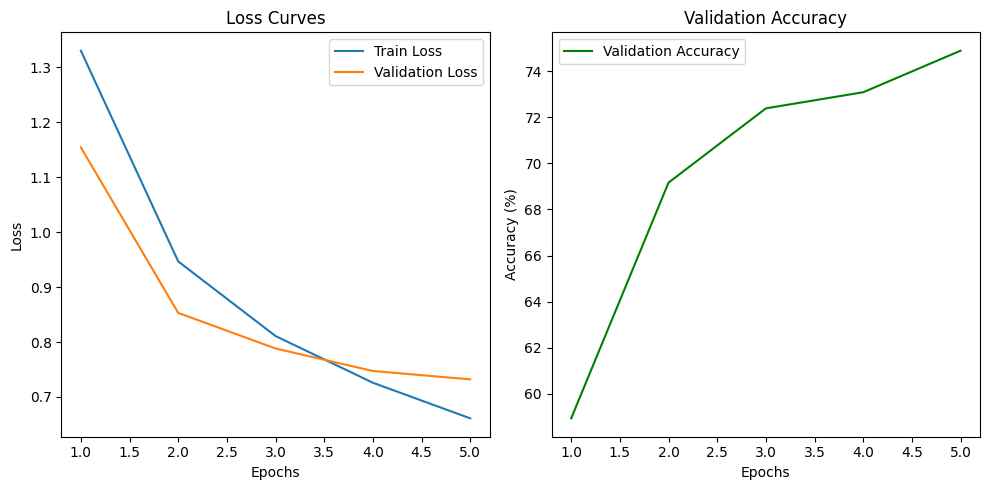


---Testing configuration: learning rate=0.001, weight decay=1e-05, dropout=0.4
Epoch [1/5] | Train Loss: 1.3564 | Val Loss: 1.0912 | Val Acc: 59.98%
Epoch [2/5] | Train Loss: 1.0053 | Val Loss: 0.9060 | Val Acc: 68.98%
Epoch [3/5] | Train Loss: 0.8648 | Val Loss: 0.8804 | Val Acc: 69.08%
Epoch [4/5] | Train Loss: 0.7823 | Val Loss: 0.7391 | Val Acc: 74.36%
Epoch [5/5] | Train Loss: 0.7124 | Val Loss: 0.7371 | Val Acc: 74.86%


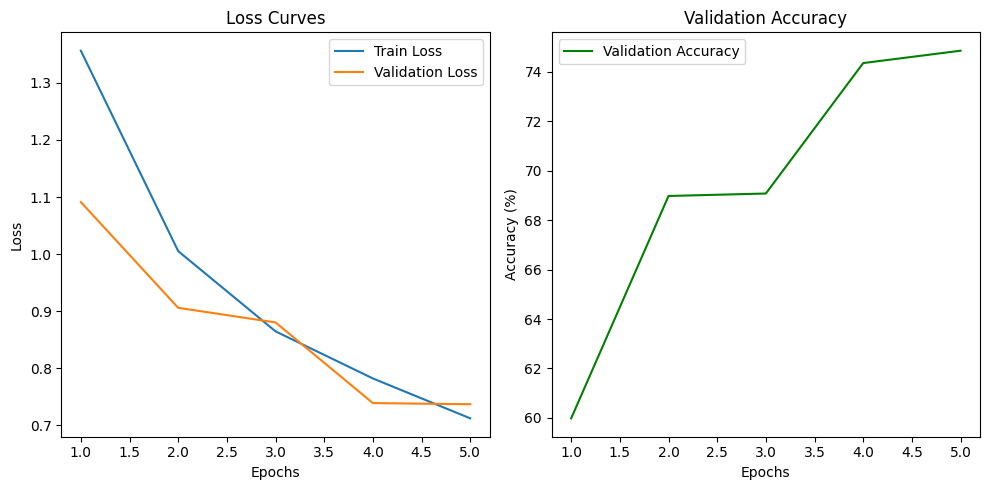


Best hyperparameters found:
   Learning rate: 0.001
   Weight decay:  0.001
   Dropout:       0.3


NameError: name 'best_val_acc' is not defined

In [ ]:
learning_rates = [1e-2, 5e-3, 1e-3]
weight_decays = [1e-3, 1e-4, 1e-5]
dropouts = [0.25, 0.3, 0.4]
criterion = nn.CrossEntropyLoss()
best_validation_accuracy = 0
best_params = None
best_model_state = None

for lr, wd, drop in itertools.product(learning_rates, weight_decays, dropouts):
    print(f"\n---Testing configuration: learning rate={lr}, weight decay={wd}, dropout={drop}")
    model = CNN(dropout=drop).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    _, _, val_accuracies = train_and_validate(model, train_loader, val_loader, epochs=5, criterion=criterion, optimizer=optimizer)
    val_acc = val_accuracies[-1]
    
    if val_acc > best_validation_accuracy:
        best_validation_accuracy = val_acc
        best_params = (lr, wd, drop)
        best_model_state = model.state_dict()
        
print(f"\nBest hyperparameters found:")
print(f"   Learning rate: {best_params[0]}")
print(f"   Weight decay:  {best_params[1]}")
print(f"   Dropout:       {best_params[2]}")
print(f"   Validation accuracy: {best_validation_accuracy:.2f}%")


best_model = CNN(dropout=best_params[2]).to(DEVICE)
best_model.load_state_dict(best_model_state)
test_loop(best_model, test_loader)

Epoch [1/10] | Train Loss: 1.3177 | Val Loss: 1.0374 | Val Acc: 61.86%
Epoch [2/10] | Train Loss: 0.9349 | Val Loss: 0.9307 | Val Acc: 66.64%
Epoch [3/10] | Train Loss: 0.7931 | Val Loss: 0.7763 | Val Acc: 73.18%
Epoch [4/10] | Train Loss: 0.6988 | Val Loss: 0.7451 | Val Acc: 73.92%
Epoch [5/10] | Train Loss: 0.6360 | Val Loss: 0.6779 | Val Acc: 75.80%
Epoch [6/10] | Train Loss: 0.5705 | Val Loss: 0.7008 | Val Acc: 75.92%
Epoch [7/10] | Train Loss: 0.5203 | Val Loss: 0.6718 | Val Acc: 77.04%
Epoch [8/10] | Train Loss: 0.4733 | Val Loss: 0.7010 | Val Acc: 76.54%
Epoch [9/10] | Train Loss: 0.4266 | Val Loss: 0.6320 | Val Acc: 77.86%
Epoch [10/10] | Train Loss: 0.3919 | Val Loss: 0.7259 | Val Acc: 77.88%


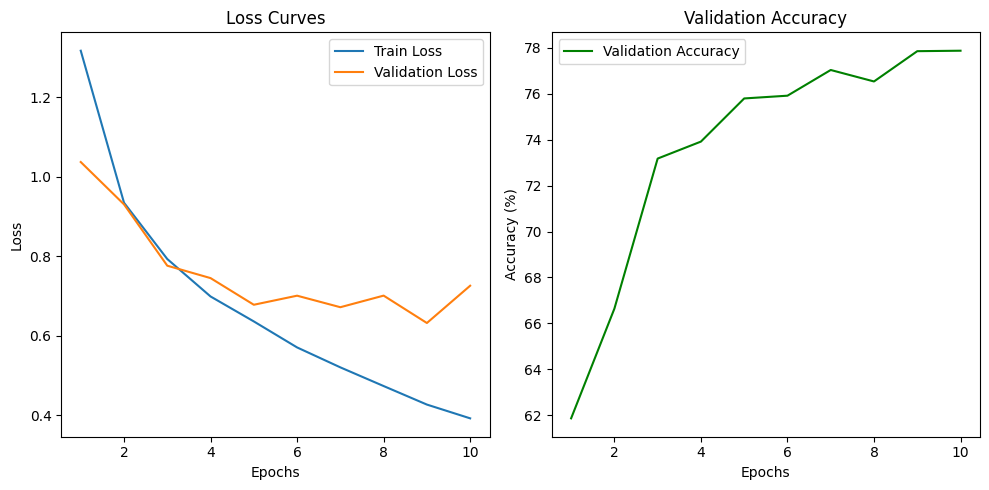


Test Accuracy: 77.70%


77.7

In [ ]:
# train_and_validate(model=model, train_loader=train_loader, val_loader=val_loader, epochs=10, criterion=criterion, optimizer=optimizer)  
# test_loop(model=model, data_loader=test_loader)

# Epoch [1/10] | Train Loss: 1.3177 | Val Loss: 1.0374 | Val Acc: 61.86%
# Epoch [2/10] | Train Loss: 0.9349 | Val Loss: 0.9307 | Val Acc: 66.64%
# Epoch [3/10] | Train Loss: 0.7931 | Val Loss: 0.7763 | Val Acc: 73.18%
# Epoch [4/10] | Train Loss: 0.6988 | Val Loss: 0.7451 | Val Acc: 73.92%
# Epoch [5/10] | Train Loss: 0.6360 | Val Loss: 0.6779 | Val Acc: 75.80%
# Epoch [6/10] | Train Loss: 0.5705 | Val Loss: 0.7008 | Val Acc: 75.92%
# Epoch [7/10] | Train Loss: 0.5203 | Val Loss: 0.6718 | Val Acc: 77.04%
# Epoch [8/10] | Train Loss: 0.4733 | Val Loss: 0.7010 | Val Acc: 76.54%
# Epoch [9/10] | Train Loss: 0.4266 | Val Loss: 0.6320 | Val Acc: 77.86%
# Epoch [10/10] | Train Loss: 0.3919 | Val Loss: 0.7259 | Val Acc: 77.88%

In [ ]:
"""
Improve current CNN
Tune training hyperparameters
Use a pre trained model (transfer learning)
train on CIFAR100
"""

'\nImprove current CNN\nTune training hyperparameters\nUse a pre trained model (transfer learning)\ntrain on CIFAR100\n'

In [ ]:
# criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# train_and_validate(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     epochs=5,
#     criterion=criterion,
#     optimizer=optimizer
# )

# test_loop(model=model,data_loader=test_loader)